## Circuit Preparation

In [1]:
from pytket.circuit import Circuit, fresh_symbol, OpType
from pytket.circuit.display import render_circuit_jupyter

## Set up bell test
circ = Circuit(2, name = "Bell Test")
circ.H(0)
circ.CX(0, 1)
circ.measure_all()

render_circuit_jupyter(circ)

## Select a Device

Select a machine and login to Quantinuum API using your crednetials

In [2]:
from pytket.extensions.quantinuum import QuantinuumBackend

machine = 'H1-1E'

backend = QuantinuumBackend(device_name = machine)
backend.login()

The device status can be checked using `device_state`

In [3]:
print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1E status:  online


or `H1-1SC` or `H1-1`. These are the only one available to us

#### Let's view all the availbale device

In [4]:
[x.device_name for x in QuantinuumBackend.available_devices()]

['H1-1SC', 'H1-1E', 'H1-1']

## Circuit Compilation

Circuit submitted to Quantinuum H-Series quantum computers and emulators run through TKET compilation passes. This enables circuits to be automatically optimized for H-series systems and run more efficiently.

The default compilation setting for circuits submited to H-Series sytems is optimization level 2



Before submitting it to the Hardware the `get_compiled_circuit` function performs the same compilation passes run after submission to Quantinuum systesms. The advantage of using this function before is to see exactly what circuit optimizations will work the best.
 
The `optimization_level` parameter in the `get_compiled_circuit` function corresponds directly to the level of optimization, which is defaulted to $2$. This package is integrated in the stack, so performing circuit optimization is redundant, but user can nevertheless do this, to check how the optimization is applied.


1. Use `optimization_level = 0` when running `get_compiled_circuit`, then submit the circuit using `process_circuits` knowing the actual level run would be $2$
2. Use the `get_compiled_circuit` function with the desired optimization lebel to observe different optimizations.
3. If you want to have no optimization, you can always set `optimization_level=0`


Let's see this in action

In [5]:
compiled_circ = backend.get_compiled_circuit(circ,optimisation_level=0)
render_circuit_jupyter(compiled_circ)

## Circuit Cost

It's always a good practice to check how many HQC's a job will cost

In [26]:
n_shots = 100
backend.cost(compiled_circ, n_shots=n_shots, syntax_checker='H1-1E')

5.66

$$ HQC = 5 + C(N_{1q} + 10 N_{2q} + 5 N_m) / 5000 $$


1. $N_{1q}$ is the number of single-qubit operations in a circuit.
2. $N_{2q}$ is the number of native two-qubit operations in a circuit. Native gate is equivalent to CNOT up to several single-qubit gates.
3. $N_m$ is the number of state preparation and measurement (SPAM) operations in a circuit including initial implicit state preparation and any intermediate and final measurements and state resets.
4. $C$ is the shot count.

#### Importing Circuit from Qiskit

In [9]:
## do the basic imports

# doing the basic imports

import numpy as np
import math
import matplotlib.pyplot as plt




# quantum imports

from qiskit import *                    # getting all the necessary qiskit packages

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.visualization import *      # visualization tools
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import IntegerComparator,TwoLocal
from qiskit.circuit.library.arithmetic import LinearAmplitudeFunction, CDKMRippleCarryAdder
from qiskit.circuit.library import RealAmplitudes

simulator = BasicAer.get_backend('qasm_simulator')  # setting the backend
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_algorithms.optimizers import optimizer, ADAM,GradientDescent, SPSA, COBYLA, GSLS, SLSQP, AQGD, NELDER_MEAD, POWELL


from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library import RYGate
from qiskit_aer.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit_aer.primitives import Sampler
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import IntegerComparator

In [16]:
qc = QuantumCircuit(15)
    #lets define the constants

p = 0.9 # price of selling the product

c1 = 0.6 # cost of buying the product from supplier 1
c2 = 0.5 # cost of buying the product from supplier 2
o = 0.9
w = 0.3
f1 = 0.2 # fixed cost of buying from supplier 1
f2 = 0.3 # fixed cost of buying from supplier 2
R1 = 0.3 # reliability of supplier 1
R2 = 0.5 # reliability of supplier 2
    
c = 0.1
   
mu = 5
sigma = 2
# loading the demand distribution
demand = NormalDistribution(num_qubits=3,mu=mu,sigma=sigma,  bounds=[0,7])
params = [np.pi/2]*18   
supply1 = RealAmplitudes(3, reps=2)
supply2 = RealAmplitudes(3, reps=2)
    # taking the parameters from the list
list1 = params[:9]
list2 = params[9:]

    
supply1 = supply1.assign_parameters(list1)
supply2 = supply2.assign_parameters(list2)

    #qc.compose(prob_circuit,qubits=[8,9,10], inplace=True)
qc.compose(demand,qubits=[8,9,10], inplace=True)
qc.compose(supply1, qubits = [0,1,2], inplace=True)
qc.compose(supply2, qubits = [3,4,5], inplace=True)

a1 = p-w
a2 = o-w
a3 = w-c1
a4 = w-c2


    # Function Loading Steps    

    # Step 1
for i in range(8,11):
    qc.cry(2*c*a1*(2**i),i,12)



    # Step 2

for i in range(0,3):
    qc.cry(2*c*a3*R1*(2**i),i,12)



    # Step 3

for i in range(3,6):
    qc.cry(2*c*a4*R2*(2**i),i,12)


    # Step 4

for i in range(8,11):
    qc.cry(-2*c*a2*(2**i),i,12)


    # Step 5

for i in range(0,3):
    qc.cry(2*c*a2*R1*(2**i),i,12)



    # Step 6

for i in range(3,6):
    qc.cry(2*c*a2*R2*(2**i),i,12)
    
qc.barrier()

    # fixed cost

qc.cnot(0,13)
qc.cnot(1,13)
qc.cnot(2,13)
qc.cnot(3,14)
qc.cnot(4,14)
qc.cnot(5,14)

qc.ccx(0,1,13)
qc.ccx(1,2,13)
qc.ccx(0,2,13)

qc.mct([0,1,2],13)
qc.ccx(3,4,14)
qc.ccx(4,5,14)
qc.ccx(3,5,14)

qc.mct([3,4,5],14)

qc.cry(-2*c*f1,13,12)
qc.cry(-2*c*f2,14,12)




    # Addition Circuit Steps
    
n = 3
z = 6

# Step 1
for i in range(1,n):
    qc.cnot(z,i)

for i in range(1,n):
    qc.cnot(z,i+n)


    # Step 2
qc.ccx(0,n,n+n)

qc.x(n)

    # Step 3

for i in range(1,n-1):
    qc.cnot(n+n,i+n)
    qc.cnot(n+n,i)
    qc.ccx(i,i+n,n+n)
    qc.ccx(i,i+n,0)

    # Step 4

qc.cnot(n+n,n+n-1)
qc.cnot(n+n,n-1)
qc.ccx(n+n-1,n-1,n+n)


    # Step 5


for i in range(1,n-1):
    qc.cnot(0,n+n-i)
    qc.ccx(2*n-i-1,n-i-1,0)

    # Step 6

for i in range(1,n-1):
    qc.ccx(0,n,2*n-i)

    # Step 7

qc.x(n)
qc.ccx(0,n,n+1)


    # Step 8
for i in range(n):
    qc.cnot(i+n,i)

    
qc.barrier()
    # subtraction
    
    
    # Step 1
for i in range(7,11):
    qc.x(i)

    # Step 2
qc.cnot(11,1)
qc.cnot(11,2)
qc.cnot(11,6)
qc.cnot(11,9)
qc.cnot(11,10)
qc.cnot(11,7)

    # Step 3
qc.ccx(0,8,11)
qc.x(8)

    # Step 4
qc.cnot(11,9)
qc.cnot(11,1)
qc.ccx(1,9,11)
qc.cnot(11,10)
qc.ccx(9,1,0)
qc.cnot(11,2)
qc.ccx(2,10,11)
qc.ccx(10,2,0)



    # Step 5
qc.cnot(11,7)
qc.cnot(11,6)
qc.ccx(6,7,11)


    # Step 6

qc.cnot(0,7)
qc.ccx(10,2,0)
qc.cnot(0,10)
qc.ccx(9,1,0)


    # Step 7
qc.ccx(0,8,7)
qc.ccx(0,8,10)

    # Step 8
qc.x(8)

qc.ccx(0,8,9)


    # Step 9

qc.cnot(8,0)
qc.cnot(9,1)
qc.cnot(10,2)
qc.cnot(7,6)


    # Step 10
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(6)
qc.x(7)
qc.x(8)
qc.x(9)
qc.x(10)



    


qc.barrier()


    #qc.x(11)
qc.cry(2*c*-100000,0,12)
qc.cry(2*c*-100000,1,12)
qc.cry(2*c*-100000,2,12)
qc.cry(2*c*-100000,6,12)
qc.cry(2*c*-100000,11,12)
qc.ry(np.pi/2,12)
    






    #return result

    #return -((result.estimation-0.5)/c)
    

In [ ]:
qc.draw('mpl')


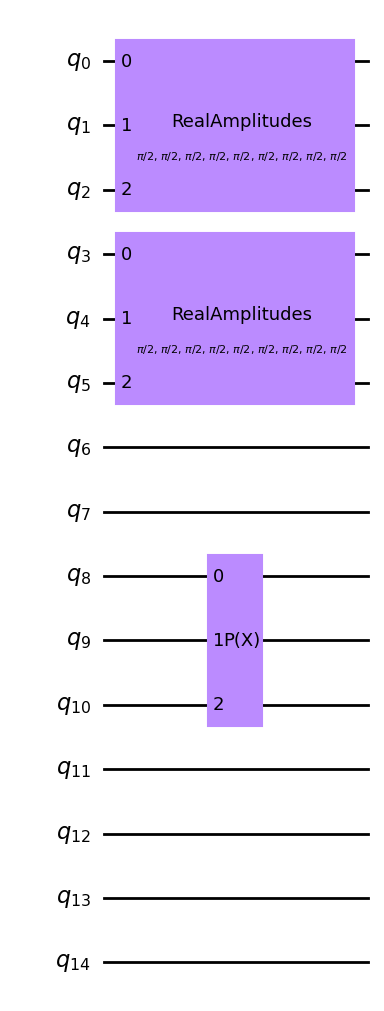

In [23]:
qc = QuantumCircuit(15)
    #lets define the constants

p = 0.9 # price of selling the product

c1 = 0.6 # cost of buying the product from supplier 1
c2 = 0.5 # cost of buying the product from supplier 2
o = 0.9
w = 0.3
f1 = 0.2 # fixed cost of buying from supplier 1
f2 = 0.3 # fixed cost of buying from supplier 2
R1 = 0.3 # reliability of supplier 1
R2 = 0.5 # reliability of supplier 2
    
c = 0.1
   
mu = 5
sigma = 2
# loading the demand distribution
demand = NormalDistribution(num_qubits=3,mu=mu,sigma=sigma,  bounds=[0,7])
params = [np.pi/2]*18   
supply1 = RealAmplitudes(3, reps=2)
supply2 = RealAmplitudes(3, reps=2)
    # taking the parameters from the list
list1 = params[:9]
list2 = params[9:]

    
supply1 = supply1.assign_parameters(list1)
supply2 = supply2.assign_parameters(list2)

    #qc.compose(prob_circuit,qubits=[8,9,10], inplace=True)
qc.compose(demand,qubits=[8,9,10], inplace=True)
qc.compose(supply1, qubits = [0,1,2], inplace=True)
qc.compose(supply2, qubits = [3,4,5], inplace=True)
qc.draw('mpl')

In [22]:
from pytket.extensions.qiskit import qiskit_to_tk
c = qiskit_to_tk(qc)

RuntimeError: Gate has an invalid number of parameters

### Revisit It later

## Run the circuit

Now run it on Quantinuum system

In [27]:
handle = backend.process_circuit(compiled_circ, n_shots=n_shots)

print(handle)

('e0dbb255ecb54b7d9f8ac4394b98fbce', 'null', 2, '[["c", 0], ["c", 1]]')


The status of a submitted job can be viewed at any time, indicating if a job is in the queue or completed. Additional information is also provided, such as queue position, start times, completion time, and circuit cost in H-Series Quantum Credits (HQCs).

In [28]:
status = backend.circuit_status(handle)
print(status)

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "Bell Test", "submit-date": "2023-11-07T04:55:42.393861", "result-date": "2023-11-07T04:55:50.880565", "queue-position": null, "cost": "5.66", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


### Retrieve Results

Results can be retrieved using`get_result` function

In [33]:
result = backend.get_result(handle)
print(result.get_counts())

Counter({(1, 1): 51, (0, 0): 49})


For large jobs, there is also the ability to return partial results for unfinished jobs

In [32]:
partial_result , job_status = backend.get_partial_result(handle)

print(partial_result.get_counts())

Counter({(1, 1): 51, (0, 0): 49})


### Save Results 

Please save your results, because Quantinuum won't

In [34]:
import json
with open('first.json', 'w') as f:
    json.dump(result.to_dict(), f)

This result can be loaded to their original format using `BackendResult.from_dict`

In [35]:
from pytket.backends.backendresult import BackendResult

with open('first.json', 'r') as f:
    data = json.load(f)

result = BackendResult.from_dict(data)

### Analyze Results

There are multiple options for analyzintg results with pytket

In [36]:
result = backend.get_result(handle)
print(result.get_counts())
print(result.get_distribution())


Counter({(1, 1): 51, (0, 0): 49})
{(0, 0): 0.49, (1, 1): 0.51}


### Cancelling the Jobs

JObs that are submitted can be cancelled

In [37]:
# it will only work if the job hasn't finished yet
backend.cancel(handle)  

QuantinuumAPIError: HTTP error attempting: job cancel.

Server Response: {'error': {'code': 22, 'message': 'Error: job has completed already'}}

## Additional Features


#### Extended Circuit Compilation



The submission below specifies this in the get_compiled_circuit function with optimization level 1. Because the circuit is optimized beforehand, the TKET optimization in the H-Series stack should be turned off. The value tket-opt-level:None turns off TKET optimization in the H-Series stack.

In [38]:
compiled_circ = backend.get_compiled_circuit(circ,optimisation_level=1)

handle = backend.process_circuit(compiled_circ, n_shots=n_shots, optiuons = {'tket-opt-level':None})

print(handle)

('7e42a1fb1db544b7ae8b384df726fec1', 'null', 2, '[["c", 0], ["c", 1]]')


In [39]:
compiled_circ = backend.get_compiled_circuit(circ,optimisation_level=0)
handle = backend.process_circuit(compiled_circ, n_shots=n_shots, optiuons = {'tket-opt-level':None})

print(handle)

('b75f47a7ab6b4aac831bf883bd9e7edc', 'null', 2, '[["c", 0], ["c", 1]]')


### Batch Submission

The batch feature on Quantinuum systems gives users the ability to create "ad-hoc" reservations. Circuits submitted together in a batch will run at one time. The benefit to users is that once a batch hits the front of the queue, jobs in a batch will run uninterrupted until they are completed.

Once a batch is submitted, jobs can continue to be added to the batch, ending either when the user signifies the end of a batch or after 1 minute of inactivity.

Batches cannot exceed the maximum limit of 2,000 H-System Quantum Credits (HQCs) total. If the total HQCs for jobs in a batch hit this limit or a smaller limit set by the user, those jobs will not be cancelled. Instead, they will continue to run as regular jobs in the queue instead of as a batch.

Currently only the quantum computer and emulator targets support the batching feature. Batching is not supported on the syntax checkers.

In [40]:
machine = 'H1-1E'
n_shots = 100
max_batch_cost = 100

backend = QuantinuumBackend(device_name = machine)

batch1 = backend.start_batch(n_shots=n_shots, max_batch_cost=max_batch_cost,circuit=compiled_circ)

Additional jobs can be added to the batch using the `add_to_batch` function. The end of a batch can optionally be specified with the `batch_end` flag.

In [41]:
batch2 = backend.add_to_batch(batch1, compiled_circ, n_shots=n_shots)
batch3 = backend.add_to_batch(batch1, compiled_circ, n_shots=n_shots, batch_end=True)

In [42]:
handle_list = [batch1, batch2, batch3]

status_list = [backend.circuit_status(h) for h in handle_list]

status_list

[CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "Bell Test", "submit-date": "2023-11-07T06:20:17.722238", "result-date": "2023-11-07T06:20:26.518390", "queue-position": null, "cost": "5.66", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None),
 CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "Bell Test", "submit-date": "2023-11-07T06:21:00.031829", "result-date": "2023-11-07T06:21:06.338484", "queue-position": null, "cost": "5.66", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None),
 CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "Bell Test", "submit-date": "2023-11-

In [43]:
results = backend.get_results(handle_list)

In [44]:
for result in results:
    print(result.get_counts())

Counter({(1, 1): 58, (0, 0): 41, (0, 1): 1})
Counter({(0, 0): 57, (1, 1): 43})
Counter({(0, 0): 50, (1, 1): 50})


## Parametrized Circuits

They are very common in variational algotrithms

In [45]:
from pytket.circuit import fresh_symbol

# set up a paramaterized circuit
a = fresh_symbol("a")
circuit = Circuit(3,name ="parameterized circuit")
circuit.X(0)
circuit.CX(0,1).CX(1,2)
circuit.Rz(a,2)
circuit.CX(1,2).CX(0,1)

render_circuit_jupyter(circuit)

In [46]:
simulation_circuit = circ.copy()
simulation_circuit.measure_all()
simulation_circuit.symbol_substitution({a:0.5})

# compile the circuit
compiled_circuit = backend.get_compiled_circuit(simulation_circuit,optimisation_level=0)

render_circuit_jupyter(compiled_circuit)

#### Getting the cost !

In [47]:
n_shots = 100
backend.cost(compiled_circuit, n_shots=n_shots, syntax_checker='H1-1E')

5.86

In [48]:
handle = backend.process_circuit(compiled_circuit, n_shots=n_shots, optiuons = {'tket-opt-level':None})

In [49]:
status = backend.circuit_status(handle)
print(status)

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "Bell Test", "submit-date": "2023-11-07T06:57:06.470334", "result-date": "2023-11-07T06:57:13.424982", "queue-position": null, "cost": "5.86", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [50]:
result = backend.get_result(handle)

In [51]:
print(result.get_counts())

Counter({(1, 1): 57, (0, 0): 41, (0, 1): 2})


### Conditional Gates

Pytket supports conditional gates. This may be for implementing error correction or reducing noise. this capability is well-supported by Quantinuum hardware, which supports mid-circuit measurement and qubit reuse.

In [52]:
from pytket.circuit import Circuit, if_bit

# crerate the circuit

circ = Circuit(name = "conditional circuit")
qreg = circ.add_q_register("q", 3)
creg = circ.add_c_register("c", 2)

# prepare q0 to be |->
circ.X(qreg[0]).H(qreg[0])

#prepare a Bell state

circ.H(qreg[1])
circ.CX(qreg[1],qreg[2])


# construct the teleportation

circ.CX(qreg[0],qreg[1])
circ.H(qreg[0])
circ.Measure(qreg[0],creg[0]).Measure(qreg[1],creg[1])

# if (creq[1] == 1)
circ.X(qreg[2], condition= if_bit(creg[1]))

circ.Z(qreg[2], condition= if_bit(creg[0]))

render_circuit_jupyter(circ)

In [57]:
from pytket.circuit import ProjectorAssertionBox
import numpy as np

proj = np.array([[0.5,-0.5],[-0.5,0.5]])

circ.add_assertion(ProjectorAssertionBox(proj), [qreg[2]], name="projector")
render_circuit_jupyter(circ)

In [58]:
machine = 'H1-1E'
n_shots = 100
backend = QuantinuumBackend(device_name=machine)
compiled_circuit = backend.get_compiled_circuit(circ)
backend.cost(compiled_circuit, n_shots=n_shots, syntax_checker='H1-1E')

6.2

In [59]:
handle = backend.process_circuit(compiled_circuit, 
                                 n_shots=n_shots)

In [60]:
status = backend.circuit_status(handle)
status

CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "conditional circuit", "submit-date": "2023-11-07T07:08:24.749897", "result-date": null, "queue-position": null, "cost": "6.2", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)

In [61]:
result = backend.get_result(handle)

In [62]:
result.get_debug_info()

{'projector': 0.98}